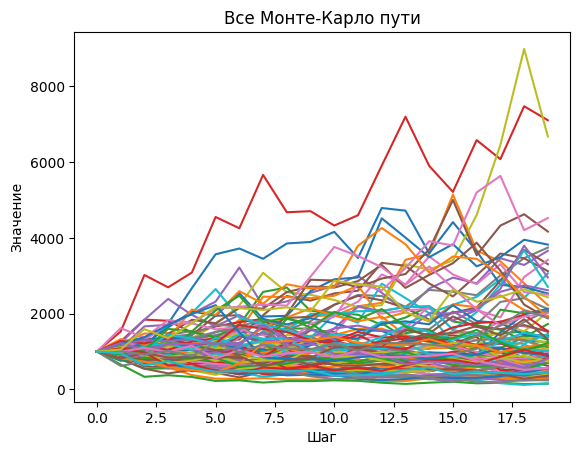

In [18]:
from lss.brownian import BrownianMotionSimulation
from src.plots import show_simulations
from lss.models import NaiveModel
from lss.algorithm import LongStaffSchwartz, OutOfSample
from lss.options import PutOption

brownian = BrownianMotionSimulation(S_0=1000, risk_free_rate=5, volatility=3)

paths = brownian.simulate(num_paths=100, len_paths=20)

show_simulations(paths)

### Как в статье

In [19]:
algo = LongStaffSchwartz()
opp = algo.evaluate(verbose=True)[1]
backtest = OutOfSample(models_list=algo.models_list)
print(algo.option_price("all"))
print(f"Interval with 95% of confidence {algo.confident_interval()}")
print("Out of Sample option price ", backtest.evaluate())
print(algo.monte_carlo_paths)
print(algo.models_list)

----- INITIAL CASH FLOW MATRIX -----
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
------------------------------------
----- CASH FLOW MATRIX AT TIME 3-----
[[0.   0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.07]
 [0.   0.   0.18]
 [0.   0.   0.  ]
 [0.   0.   0.2 ]
 [0.   0.   0.09]
 [0.   0.   0.  ]]
------------------------------------
----- CASH FLOW MATRIX AT TIME 2 -----
[[0.   0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.07]
 [0.   0.13 0.  ]
 [0.   0.   0.  ]
 [0.   0.33 0.  ]
 [0.   0.26 0.  ]
 [0.   0.   0.  ]]
-----------------------------------------
----- CASH FLOW MATRIX AT TIME 1 -----
[[0.   0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.07]
 [0.17 0.   0.  ]
 [0.   0.   0.  ]
 [0.34 0.   0.  ]
 [0.18 0.   0.  ]
 [0.22 0.   0.  ]]
-----------------------------------------
----- DECISION MATRIX -----
[[0 0 0]
 [0 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]
---------------------------
Evolute the option price:  0

### Эксперименты


Проверим правильность реализации in sample и out of sample, то что цены американского и европеского опыионов должны совпадать

In [20]:
import numpy as np

# --------------------
NUM_PATHS = 5000
PATH_LEN = 3
STRIKE = 1750
START_REAL_PRICE = 2027.517212
RISK_FREE_RATE = 5.0
VOLATILITY = 78.8
# --------------------

brownian = BrownianMotionSimulation(S_0=START_REAL_PRICE, risk_free_rate=RISK_FREE_RATE, volatility=VOLATILITY)
simulations = brownian.simulate(num_paths=NUM_PATHS, len_paths=PATH_LEN)


naive_model = NaiveModel(risk_free_rate=RISK_FREE_RATE)

algo = LongStaffSchwartz(
    risk_free_rate=RISK_FREE_RATE,
    option=PutOption(),
    strike=STRIKE,
    monte_carlo_paths=simulations,
    model=naive_model
)

algo.evaluate(verbose=False)


backtest = OutOfSample(
    risk_free_rate=RISK_FREE_RATE,
    option=PutOption(),
    strike=STRIKE,
    monte_carlo_paths=simulations,
    models_list=algo.models_list
)

print(algo.option_price("all"))
print("Out of Sample american option price:", backtest.evaluate()[0], "\nOut of Sample european option price:", backtest.evaluate()[1])
print(f"Interval with 95% of confidence {algo.confident_interval()}")

Evolute the option price:  1656.2876086610365 
European option price:  1577.9876042591327
Out of Sample american option price: 1656.2876086610365 
Out of Sample european option price: 1577.9876042591327
Interval with 95% of confidence 1.05742276286387


In [22]:
from tqdm.notebook import tqdm
# ------- ENVS -------
# --------------------
NUM_PATHS = 2000
PATH_LEN = 4
STRIKE = 20.1
START_REAL_PRICE = 20
RISK_FREE_RATE = 5.8239
VOLATILITY = 3
# --------------------
# --------------------

prices_in_sample = []
prices_out_of_sample = []
strike = []
conf_intervals = []

brownian = BrownianMotionSimulation(S_0=START_REAL_PRICE, risk_free_rate=RISK_FREE_RATE, volatility=VOLATILITY)
lss_paths = brownian.simulate(num_paths=NUM_PATHS, len_paths=PATH_LEN)
oos_paths = brownian.simulate(num_paths=NUM_PATHS, len_paths=PATH_LEN)

naive_model = NaiveModel(risk_free_rate=RISK_FREE_RATE)
option_model = PutOption()

lss_paths

array([[20.        , 20.39358603, 21.0761249 , 19.15405575],
       [20.        , 19.81792982, 19.37550435, 21.54144969],
       [20.        , 22.28274984, 17.36077688, 20.30929107],
       ...,
       [20.        , 13.85262507, 19.20534712, 24.38583999],
       [20.        , 16.45523742, 18.15184837, 18.77950496],
       [20.        , 24.56109545, 22.49691279, 21.97108652]])

In [23]:
lss_model = LongStaffSchwartz(
        risk_free_rate=RISK_FREE_RATE,
        option=option_model,
        strike=STRIKE,
        monte_carlo_paths=lss_paths,
        model=naive_model
    )
_, lss_price = lss_model.evaluate(verbose=False)
    
models_after_train: list = list(lss_model.models_list)

models_after_train

[poly1d([ 0.03173773, -1.78120568, 24.3095328 ]),
 poly1d([ 0.02329319, -1.54071521, 22.48741656])]

In [24]:
for i in tqdm(range(800)):
    strike.append(STRIKE)
    
    lss_model = LongStaffSchwartz(
        risk_free_rate=RISK_FREE_RATE,
        option=option_model,
        strike=STRIKE,
        monte_carlo_paths=lss_paths,
        model=naive_model
    )
    _, lss_price = lss_model.evaluate(verbose=False)
    
    models_after_train: list = list(lss_model.models_list)
    
    oos_model = OutOfSample(
        risk_free_rate=RISK_FREE_RATE,
        models_list=models_after_train,
        strike=STRIKE,
        option=option_model,
        monte_carlo_paths=oos_paths
    )
    oos_price, _ = oos_model.evaluate()

    STRIKE -= 0.01
    conf_intervals.append(lss_model.confident_interval())
    prices_in_sample.append(lss_price)
    prices_out_of_sample.append(oos_price)


  0%|          | 0/800 [00:00<?, ?it/s]

In [25]:
up_border = [x + y for x, y in zip(prices_in_sample, conf_intervals)]
low_border = [x - y for x, y in zip(prices_in_sample, conf_intervals)]

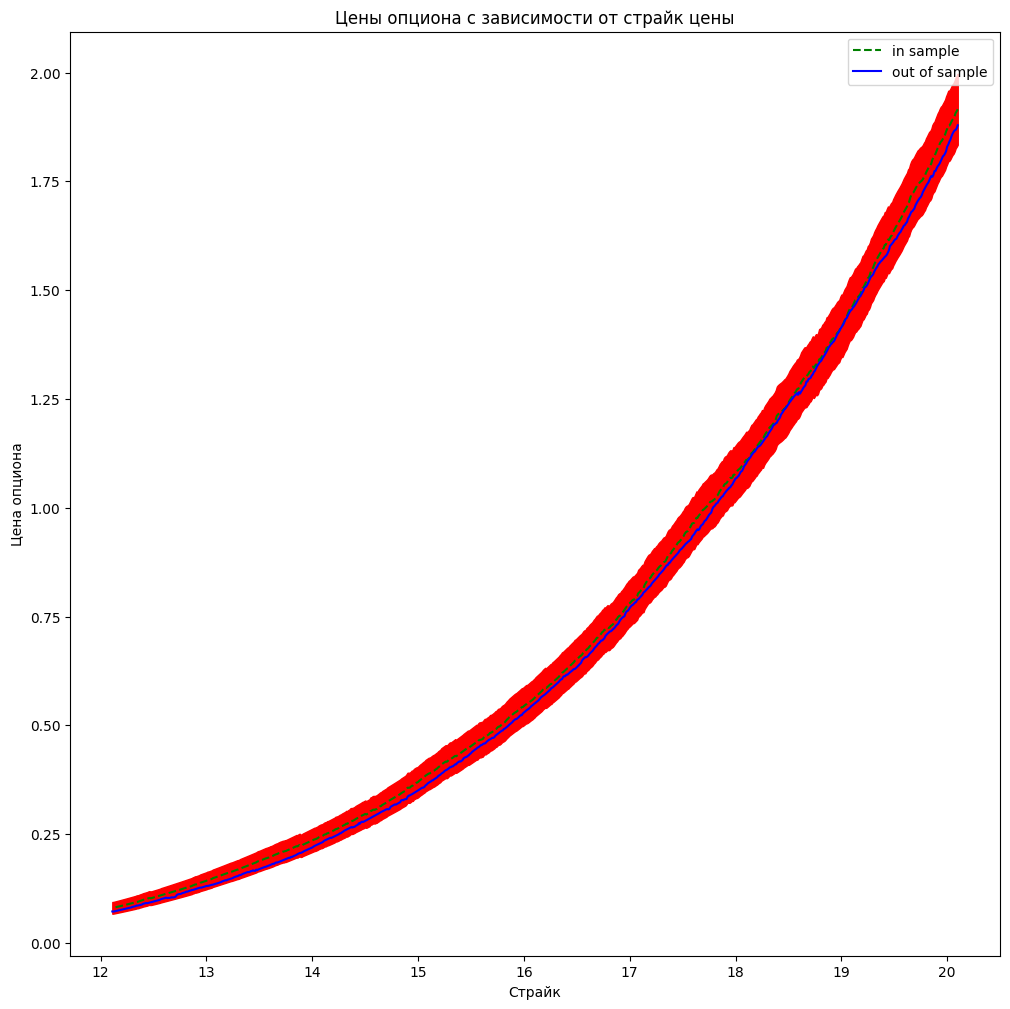

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
plt.plot(strike, prices_in_sample, linestyle='--', color='g', label='in sample')
plt.plot(strike, prices_out_of_sample, linestyle='-', color='b', label='out of sample')
plt.ylabel('Цена опциона')
plt.xlabel('Cтрайк')
ax.fill_between(strike, up_border, low_border, color='r')
plt.legend()
plt.title("Цены опциона с зависимости от страйк цены")
plt.show()

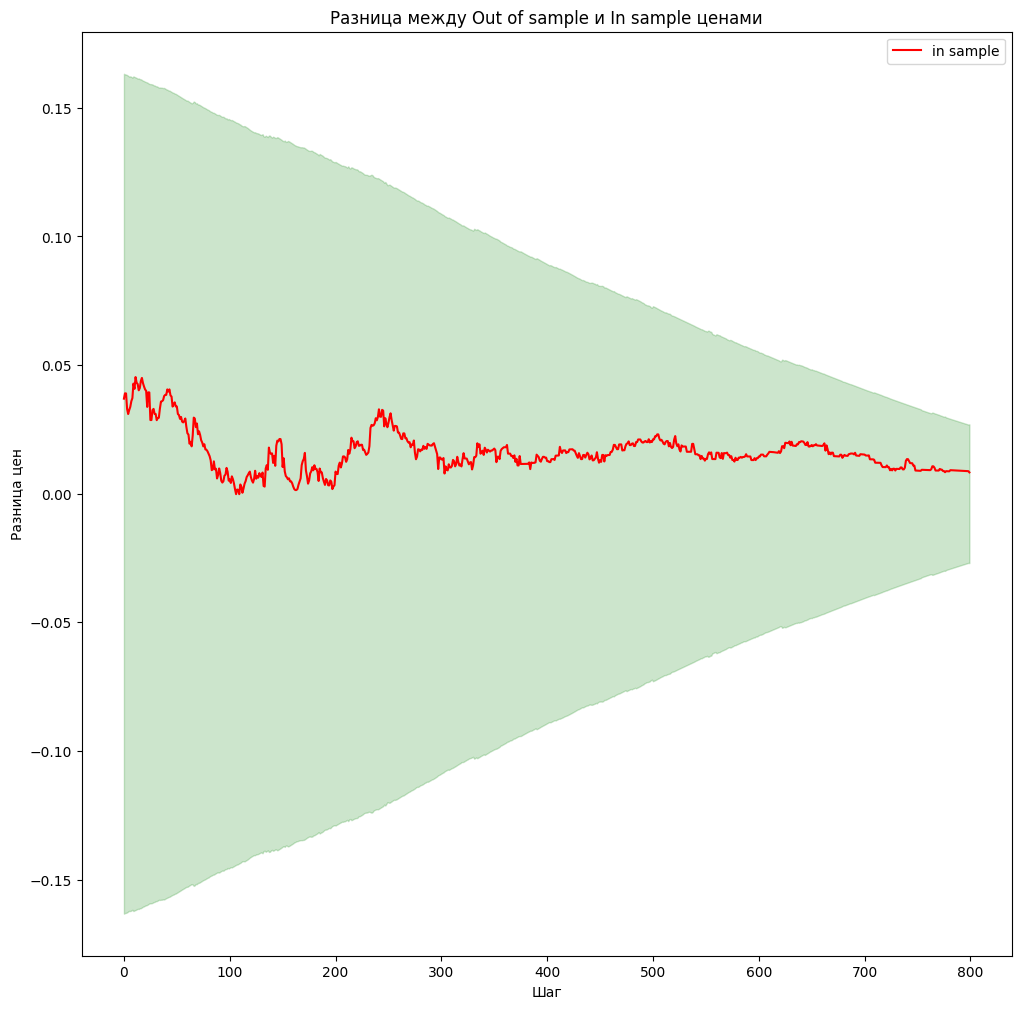

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
plt.plot(
    np.arange(0,len(prices_out_of_sample)),
    np.array(prices_in_sample) - np.array(prices_out_of_sample), 
    linestyle='-',
    color='r', 
    label='in sample'
)
plt.fill_between(
    np.arange(0,len(prices_out_of_sample)),
    np.array(up_border) - np.array(low_border),
    np.array(low_border) - np.array(up_border),
    color='g',
    alpha=0.2,
)
plt.ylabel('Разница цен')
plt.xlabel('Шаг')
plt.legend()
plt.title("Разница между Out of sample и In sample ценами")
plt.show()